In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io
import skimage.transform
import xml.etree.ElementTree as ET

from platform import python_version
import tensorflow as tf
import psutil
import multiprocessing as mp
import shutil

from sklearn.model_selection import train_test_split
import keras
from keras import backend as K
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet201, DenseNet169, DenseNet121
from keras.applications.nasnet import NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, GlobalAveragePooling1D
from keras import optimizers
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
from keras.utils import multi_gpu_model

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import gc
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

print("py", python_version())
print("tf", tf.__version__)
print("keras", tf.keras.__version__)
mem = psutil.virtual_memory()
print("mem", mem.total/1024/1024)
cpu = mp.cpu_count()
print("cpu", cpu)

%system nvidia-smi

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

py 3.7.5
tf 1.15.0-rc3
keras 2.2.4-tf
mem 32654.578125
cpu 4


['Mon Aug 10 01:18:57 2020       ',
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 432.00       Driver Version: 432.00       CUDA Version: 10.1     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  P106-100            TCC  | 00000000:01:00.0 Off |                  N/A |',
 '| 29%   32C    P8     6W / 120W |   5943MiB /  6077MiB |      0%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '|   1  P106-100            TCC  | 00000000:09:00.0 Off |                  N/A |',
 '| 34%   31C    P8     5W / 120W |    221MiB /  6077MiB |      0%      Default |',
 '+-------------------------------+-----

In [30]:
class Utils():
    def __init__(self, N=120, datasetPath='./Data/Training/', annotationPath='./Data/Annotation/'):
        self.datasetPath = datasetPath
        self.annotationPath = annotationPath
        self.folderList = []
        self.N = N

    def init(self):
        self.folderList = []
        if (self.N > 120):
            self.N = 120

    def readDatasetFolderName(self):
        root = os.listdir(self.datasetPath)
        for i in root:
            if (i == '.DS_Store'):
                continue
            self.folderList.append(i)
        self.folderList.sort()

    def loadDataset(self):
        images = []
        labels = []
        self.readDatasetFolderName()
        count = 0
        for i in self.folderList[0:self.N]:
            imgList = os.listdir(self.datasetPath + '/' + i)
            annotationList = os.listdir(self.annotationPath + '/' + i)
            for j, a in zip(imgList, annotationList):
                imgPath = self.datasetPath + '/' + i + '/' + j
                annotationPath = self.annotationPath + '/' + i + '/' + a
                img = np.array(self.loadImg(imgPath, annotationPath, 299, 299))
                images.append(np.array(img))
                labels.append(np.array([1 if k == count else 0 for k in range(self.N)]))
                del img
            count = count + 1
            print("Finish to loading %d category: %s" % (count, i))
        gc.collect()
        print(len(labels))
        return images, labels

    def loadImg(self, path, annotation=None, x=224, y=224):
        if (annotation != None):
            tree = ET.parse(annotation)
            xmin = int(tree.getroot().findall('.//xmin')[0].text)
            xmax = int(tree.getroot().findall('.//xmax')[0].text)
            ymin = int(tree.getroot().findall('.//ymin')[0].text)
            ymax = int(tree.getroot().findall('.//ymax')[0].text)
            img = Image.open(path)
            img = img.crop((xmin, ymin, xmax, ymax))
            img = img.convert('RGB')
            img = img.resize((x, y), Image.BILINEAR)
        elif (annotation == None):
            img = Image.open(path)
            img = img.convert('RGB')
            img = img.resize((x, y), Image.BILINEAR)
        return img

    def loadTestImg(self, path, x=224, y=224):
        testImg = []
        img = Image.open(path)
        img = img.convert('RGB')
        img = img.resize((x, y), Image.BILINEAR)
        img = np.array(img)
        testImg.append(img)
        testImg = np.array(testImg)
        return testImg
    
    def showReport(self, history):
        # Show the accuracy report.
        plt.figure('Accuracy')
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

        # Show the loss report.
        plt.figure('Loss')
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left') 
        plt.show()

        # Show the error report.
        plt.figure('Error')
        plt.plot(history.history['mse'])
        plt.plot(history.history['val_mse'])
        plt.title('Model Mean Squared Error')
        plt.ylabel('mean_squared_error')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left') 
        plt.show()

        # # Show the learning rate report.
        # plt.figure('Learning Rate')
        # plt.plot(history.history['lr'])
        # plt.title('Model Learning Rate')
        # plt.ylabel('learning rate')
        # plt.xlabel('epoch')
        # plt.show()

In [31]:
class TrainingMachine:
    def __init__(self, classN=120):
        self.utils = Utils()
        self.trainX = []
        self.trainY = []
        self.testX = []
        self.testY = []
        self.classN = classN
        self.model = None
        self.parallelModel = None
        self.reduceLR = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.001,
                                          patience=20,
                                          verbose=1,
                                          mode='auto',
                                          min_delta=.0001,
                                          cooldown=0,
                                          min_lr=0.00000001)
        self.earlyStop = EarlyStopping(monitor='val_loss',
                                       min_delta=.0002,
                                       patience=30,
                                       verbose=1,
                                       mode='auto',
                                       baseline=None,
                                       restore_best_weights=True)
        self.lambdaCallback = LambdaCallback(on_epoch_begin=self.epochBegin)
        self.dataGen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, featurewise_center=True, featurewise_std_normalization=True, rotation_range=15, rescale=1./255, shear_range=0.1, zoom_range=0.2, horizontal_flip=True, channel_shift_range=50)

    def init(self):
        x, y = self.utils.loadDataset()
        self.trainX, self.testX, self.trainY, self.testY = train_test_split(x, y, test_size=0.3, random_state=0)
        del x, y
        self.convertNpArray()
    
    def convertNpArray(self):
        self.trainX = np.array(self.trainX)
        self.trainY = np.array(self.trainY)
        self.testX = np.array(self.testX)
        self.testY = np.array(self.testY)

    def top3Accuracy(self, y_true, y_pred):
        return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)
        self.__name__ = "top3Accuracy"
    
    def top5Accuracy(self, y_true, y_pred):
        return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)
        self.__name__ = "top5Accuracy"

    def topKAccuracy(self, model, k=3, testX=[], testY=[]):
        predict = model.predict_proba(testX)
        count = 0
        for i in range(len(predict)):
            topK = sorted(
                range(len(predict[i])), key=lambda x: predict[i][x], reverse=True)[:k]
            for j in topK:
                if (j == np.argmax(testY[i])):
                    count = count + 1
        meanAccuracy = (count / len(predict)) * 100
        print("Top " + str(k) + " Accuracy is: " + str(meanAccuracy))

    def epochBegin(self, epoch, logs):
        print("Start of " + str(epoch) + " Epoch. Learning Rate: " +
              str(K.eval(self.model.optimizer.lr)))

    def trainTFXception(self, ep=10, batch=10):
        pretrainingModel = Xception(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

        self.model = Sequential()

        self.model.add(pretrainingModel)

        self.model.add(GlobalAveragePooling2D(input_shape=self.trainX.shape[1:]))
        self.model.add(Dense(2048, activation='relu'))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(1536, activation='relu'))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(2048, activation='relu'))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(self.classN, activation='softmax'))

        self.model.summary()

        self.model.compile(optimizer=optimizers.RMSprop(lr=0.000001), loss='categorical_crossentropy', metrics=['mse', 'accuracy', self.top3Accuracy, self.top5Accuracy])

        # trainBatch = self.dataGen.flow(self.trainX, self.trainY, batch_size=batch)

        # history = self.model.fit_generator(trainBatch, callbacks=[self.reduceLR, self.earlyStop, self.lambdaCallback], epochs=ep, steps_per_epoch=((len(self.trainX) * 1) / batch), validation_data=(self.testX, self.testY))

        history = self.model.fit(self.trainX, self.trainY, epochs=ep, batch_size=batch, validation_data=(self.testX, self.testY), callbacks=[self.earlyStop, self.lambdaCallback])
        
#         self.model.save_weights('/kaggle/output/kaggle/working/TF_Xception_Dropout05_2048_1536_2048_RMSprop_LR00001.h5')
        
        self.topKAccuracy(self.model, k=1, testX=self.testX, testY=self.testY)
        self.topKAccuracy(self.model, k=3, testX=self.testX, testY=self.testY)
        self.topKAccuracy(self.model, k=5, testX=self.testX, testY=self.testY)
        self.utils.showReport(history)

p5Accuracy: 0.9895
Epoch 15/100
Start of 14 Epoch. Learning Rate: 1e-06
14406/14406 [==============================] - 910s 63ms/step - loss: 1.7833 - mse: 0.0054 - accuracy: 0.6130 - top3Accuracy: 0.8495 - top5Accuracy: 0.9140 - val_loss: 0.8819 - val_mse: 0.0030 - val_accuracy: 0.8406 - val_top3Accuracy: 0.9731 - val_top5Accuracy: 0.9901
Epoch 16/100
Start of 15 Epoch. Learning Rate: 1e-06
14406/14406 [==============================] - 915s 64ms/step - loss: 1.6167 - mse: 0.0050 - accuracy: 0.6284 - top3Accuracy: 0.8713 - top5Accuracy: 0.9300 - val_loss: 0.7579 - val_mse: 0.0026 - val_accuracy: 0.8513 - val_top3Accuracy: 0.9751 - val_top5Accuracy: 0.9903
Epoch 17/100
Start of 16 Epoch. Learning Rate: 1e-06
14406/14406 [==============================] - 912s 63ms/step - loss: 1.4605 - mse: 0.0047 - accuracy: 0.6533 - top3Accuracy: 0.8883 - top5Accuracy: 0.9409 - val_loss: 0.6658 - val_mse: 0.0023 - val_accuracy: 0.8605 - val_top3Accuracy: 0.9781 - val_top5Accuracy: 0.9913
Epoch 18/100

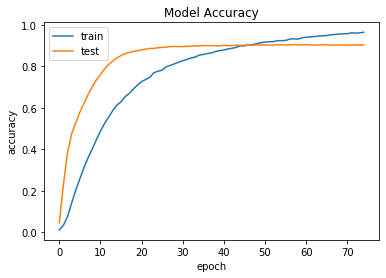

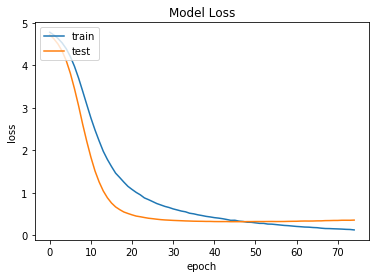

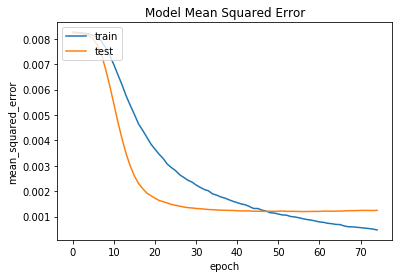

In [32]:
def main():
    trainingMachine = TrainingMachine(classN=120)
    trainingMachine.init()
    trainingMachine.trainTFXception(100, 10)

if __name__ == '__main__':
    main()